First, load the data,in this notebook we are using the second Qitta data from the paper "Machine learning–based feature selection to search stable microbial biomarkers: application to inflammatory bowel disease". The data has been preprocessed in R (refer to the r script in iCloud/UTK/GRA-UTK/SelectMicro/MLonMicrobiome).

2) 836 samples: Flores GE, Caporaso JG, Henley JB, et al. Temporal variability is a personalized feature of the human microbiome. Genome Biol 2014

This dataset has more healthy samples.

The result is from sbatch script:

In [1]:
import sys
sys.path.append('/lustre/isaac24/scratch/mhe8/SelectMicro_24/Code')
import loadData 
import RunML
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

import scikit_posthocs as sp
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt

2025-04-30 15:10:26.628281: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 15:10:28.281563: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 15:10:28.307662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746040228.353160 1596732 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746040228.380779 1596732 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 15:10:31.528995: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
count_db1269 = pd.read_csv('../../data/genus/data_filtered99/features_db2151.csv',index_col=0)

In [3]:
meta_db1269 = pd.read_csv('../../data/genus/data_filtered99/meta_db2151.csv',index_col=0)
tax_db1269 = pd.read_csv('../../data/genus/data_filtered99/tax_db2151.csv',index_col=0)
tax_db1269.index = tax_db1269.index.astype(str)

In [4]:
print(count_db1269.shape)

(836, 346)


In [5]:
# 1. abundance matrix--> relative abundance matrix
cols_name = count_db1269.columns
data = pd.DataFrame(FS.relative_abundance(count_db1269), columns=cols_name)

In [6]:
y = meta_db1269['ibd']

In [7]:
set(y)
# nonIBD: Individuals without IBD (healthy controls).
# CD: Crohn’s Disease.
# UC: Ulcerative Colitis.

{'CD', 'UC', 'nonIBD'}

In [8]:
pd.Series(y).value_counts()

ibd
nonIBD    804
UC         22
CD         10
Name: count, dtype: int64

Perform sigle lable feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a weighted h score.

dict_keys(['selected_df', 'selected_indices', 'H_score'])

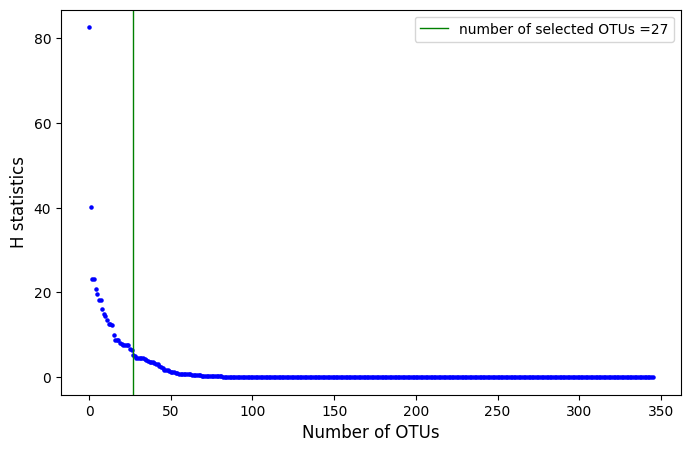

In [9]:
# 2. calculating H score for each OTU
selectedresult=FS.SelectMicro_fun(data,y,p_cutoff = 0.05)

selectedresult.keys()

In [10]:
selectedOTU_index= selectedresult['selected_indices']
X_FS = selectedresult['selected_df']

In [11]:
selected_tax_FS = tax_db1269.loc[X_FS.columns,'Rank']
print(selected_tax_FS)

1099710    p__Firmicutes_c__Clostridia_o__Clostridiales_f...
4393532    p__Actinobacteria_c__Coriobacteriia_o__Corioba...
4461490    p__Tenericutes_c__Mollicutes_o__Mycoplasmatale...
2530636    p__Firmicutes_c__Clostridia_o__Clostridiales_f...
4480529    p__Firmicutes_c__Clostridia_o__Clostridiales_f...
4436552    p__Bacteroidetes_c__Bacteroidia_o__Bacteroidal...
4453609    p__Bacteroidetes_c__Bacteroidia_o__Bacteroidal...
4476950    p__Firmicutes_c__Clostridia_o__Clostridiales_f...
994357     p__Firmicutes_c__Clostridia_o__Clostridiales_f...
4480244    p__Firmicutes_c__Clostridia_o__Clostridiales_f...
4468234    p__Bacteroidetes_c__Bacteroidia_o__Bacteroidal...
1096610    p__Firmicutes_c__Clostridia_o__Clostridiales_f...
4397098    p__Firmicutes_c__Clostridia_o__Clostridiales_f...
3805726    p__Firmicutes_c__Clostridia_o__Clostridiales_f...
3855938    p__Firmicutes_c__Erysipelotrichi_o__Erysipelot...
4481131    p__Firmicutes_c__Clostridia_o__Clostridiales_f...
2407149    p__Firmicutes

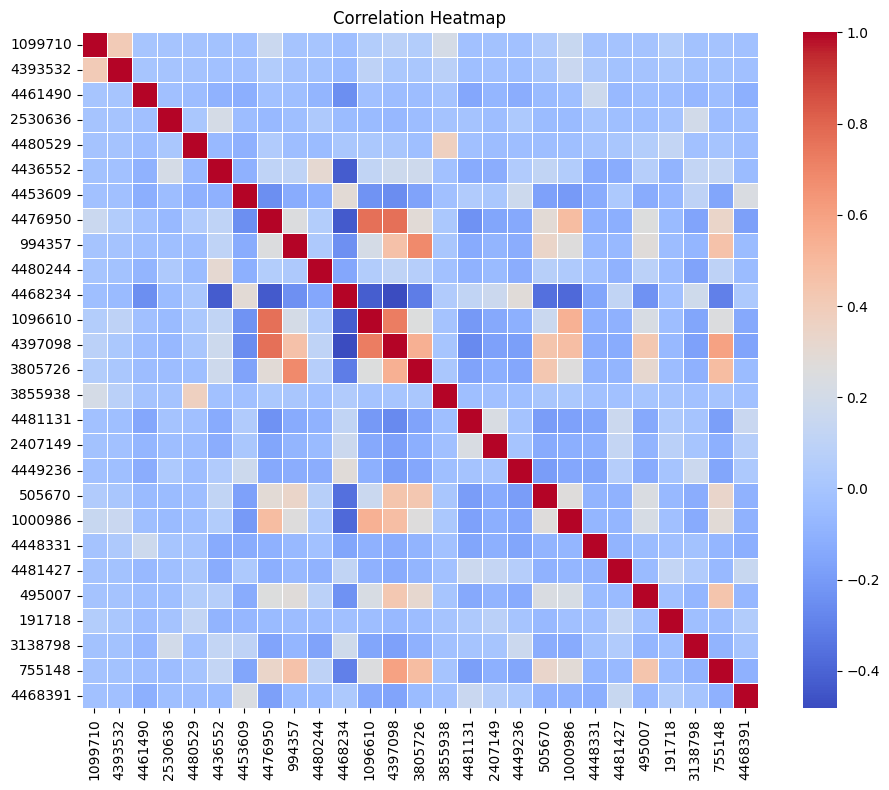

In [12]:
# Compute correlation matrix
corr = X_FS.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [13]:
custom_order = ['nonIBD', 'CD', 'UC']
custom_mapping = {category: i for i, category in enumerate(custom_order)}
target_variable = [custom_mapping[category] for category in y]
target_variable = np.array(target_variable)

In [ ]:
X_lasso_ft0,selectedOTU_index_Lasso  = RunML.LassoFS_CV_classification(np.array(data),target_variable)
X_lasso_ft = pd.DataFrame(X_lasso_ft0, columns=cols_name[selectedOTU_index_Lasso])

X_FS_lasso_ft0,xlabel_FS_lasso_ft0  = RunML.LassoFS_CV_classification(np.array(X_FS),target_variable)
selectedOTU_index_FS_lasso = selectedOTU_index[xlabel_FS_lasso_ft0]
X_FS_lasso_ft = pd.DataFrame(X_FS_lasso_ft0, columns=cols_name[selectedOTU_index_FS_lasso])

Best C: 9.999999999999999e-05


In [ ]:
X_lasso_ft0

In [ ]:
print(f'The shape of the original dataset is ',np.shape(data))
print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))
print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))


In [ ]:
data_subset = {"AllFeatures":data,
               "SelectMicro": X_FS,
               #"Lasso_finetune":X_lasso_ft,
               #"FS_Lassofinetune":X_FS_lasso_ft
              }

In [ ]:
group = pd.DataFrame({'Disease': y})
group.index = meta_db1269.index
group = group.loc[count_db1269.index]# align disease based on index of count matrix

for datatype, subset in data_subset.items():
    subset.index = count_db1269.index
    metric.plot_heatmap(subset,group)

In [ ]:
for datatype, subset in data_subset.items():
    if datatype != "AllFeatures":
        print(datatype)
        FS.plotPresenseRatio(np.array(subset),y,subset.columns,posLabel="nonIBD",posText="nonIBD",negText="IBD")

In [ ]:
dunn_results, summary = FS.calculate_dunn_tests_pair(
    X_FS,
    target_variable,
    p_threshold=0.05
)

# Set pandas to display all rows
pd.set_option('display.max_rows', None)
# Assuming your dataframe is named df
print(summary)
# Optionally, reset back to default if needed
pd.reset_option('display.max_rows')

In [ ]:
subset = summary[summary['Group1'] == 1]['Feature'].unique()
subset= subset.tolist()

dunn_feature = tax_db1269.loc[tax_db1269.index.isin(subset),'Rank']
print(dunn_feature)


### plot for a feature



In [ ]:
# select some of the features
for feature in subset:
    df_dunntest_x = X_FS[[feature]].copy()
    df_dunntest_x['Group'] = y.values
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=df_dunntest_x, x='Group', y=feature, hue='Group', palette='Set2', legend=False)
    sns.stripplot(data=df_dunntest_x, x='Group', y=feature, color='black', alpha=0.3, jitter=True)
    plt.ylabel("Relative abundance")  # Replace with your desired title
    plt.title(f"{dunn_feature.loc[feature]}")
    plt.tight_layout()
    plt.show()
    print(summary.loc[summary['Feature']==feature,:])
